In [1]:
import time
import torch
import torchvision
import numpy as np
import pandas as pd
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
from torchvision.utils import make_grid
import matplotlib.pyplot as plt


In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("No GPU available. Using CPU.")




GPU is available. Using GPU.


In [3]:
import GPUtil
import psutil

gpus = GPUtil.getGPUs()
for gpu in gpus:
    print(f"GPU: {gpu.name}, Driver: {gpu.driver}, Memory: {gpu.memoryTotal}MB")

ram = psutil.virtual_memory()
print(f"Total RAM: {ram.total / (1024**3):.2f} GB")

GPU: NVIDIA GeForce RTX 4070 Laptop GPU, Driver: 556.12, Memory: 8188.0MB
Total RAM: 15.70 GB


In [4]:

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.data import DataLoader, TensorDataset

data_directory = 'Sign Language for Alphabets'



In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    
])

dataset = datasets.ImageFolder(root=data_directory, transform=transform)




In [6]:
total_images = len(dataset)
class_distribution = {dataset.classes[i]: sum([1 for _, label in dataset if label == i]) for i in range(len(dataset.classes))}

In [7]:
print(f'Total number of images: {total_images}')
print('Class distribution:')
for class_name, count in class_distribution.items():
    print(f'{class_name}: {count}')

Total number of images: 39622
Class distribution:
a: 2339
b: 2341
c: 2187
d: 2179
e: 798
f: 2220
g: 1845
h: 664
i: 2160
j: 300
k: 619
l: 2146
m: 577
n: 593
o: 2174
p: 2021
q: 575
r: 591
s: 614
t: 280
u: 586
unknown: 1500
v: 2137
w: 2147
x: 2110
y: 2119
z: 1800


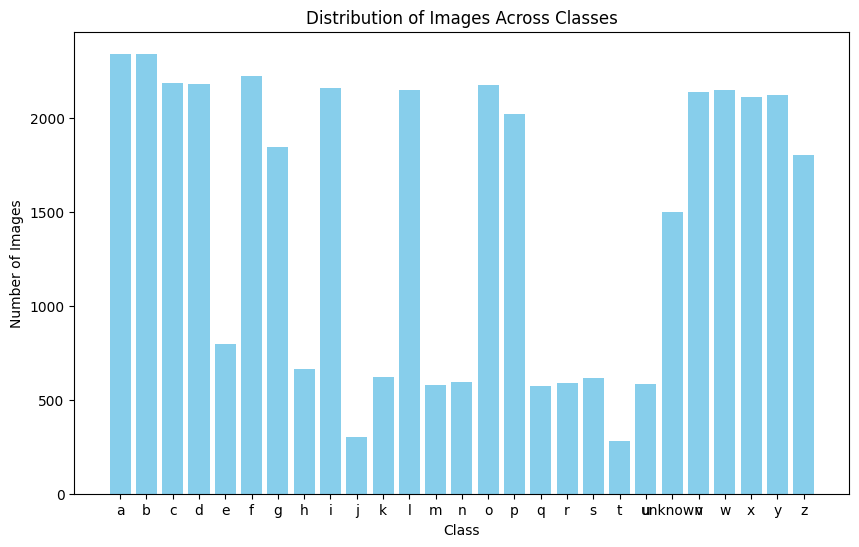

In [8]:
classes = list(class_distribution.keys())
counts = list(class_distribution.values())

plt.figure(figsize=(10, 6))
plt.bar(classes, counts, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Images Across Classes')
# plt.xticks(rotation=45)
plt.show()

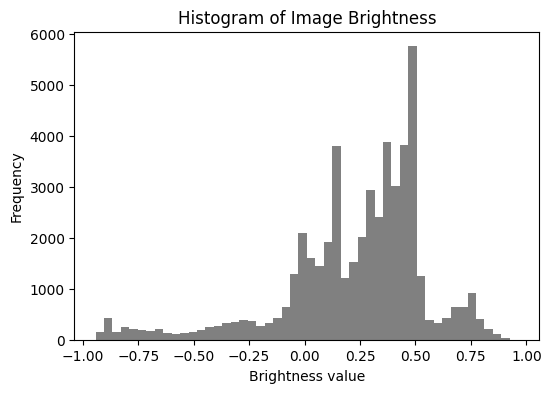

In [9]:
s_image = dataset[0][0].mean(0)
brightness_values = s_image.flatten()

plt.figure(figsize=(6, 4))
plt.hist(brightness_values, bins=50, color='gray')
plt.title('Histogram of Image Brightness')
plt.xlabel('Brightness value')
plt.ylabel('Frequency')
plt.show()


In [6]:
train_size = int(0.7 * len(dataset))
test_size = int(0.15 * len(dataset))
validation_size = len(dataset) - (train_size + test_size)

In [7]:
print(len(dataset))

39622


In [8]:
train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


images.shape: torch.Size([16, 3, 224, 224])
tensor([15, 24, 25,  5, 14, 22,  0,  6, 17, 11,  8, 13,  1, 25, 22,  1])


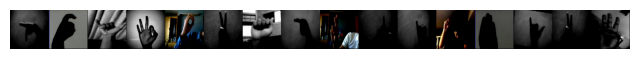

In [9]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    print(labels)
    plt.figure(figsize=(8,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [10]:
import torch.nn as nn

class VGG13(nn.Module):
    def __init__(self, num_classes=27):  
        super(VGG13, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3,  stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3,  stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes), 
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  
        x = self.classifier(x)
        return x


model = VGG13()


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
model = model.to(device)  
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [12]:
import time
from tqdm import tqdm  # Import tqdm for progress bar

start_time = time.time()
num_epochs = 50
val_accuracies = []
train_accuracies = []
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct_train = 0
    total_train = 0

    # Add progress bar for training loop
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Training]")
    
    for inputs, targets in train_loader_tqdm:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted_train = torch.max(outputs, 1)
        total_train += targets.size(0)
        correct_train += (predicted_train == targets).sum().item()

        # Update progress bar with current loss
        train_loader_tqdm.set_postfix(loss=loss.item())

    average_loss = total_loss / len(train_loader)
    train_losses.append(average_loss)

    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
            _, predicted_val = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted_val == labels).sum().item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {average_loss:.4f}, '
          f'Train Accuracy: {train_accuracy:.2%}, Validation Loss: {val_loss:.4f}, '
          f'Validation Accuracy: {val_accuracy:.2%}')

end_time = time.time()
time_to_train = end_time - start_time
print(f"Time to train: {time_to_train:.2f} seconds")


Epoch 1/50 [Training]: 100%|██████████| 1734/1734 [10:05<00:00,  2.86it/s, loss=0.793] 


Epoch [1/50], Train Loss: 1.8571, Train Accuracy: 44.42%, Validation Loss: 0.7088, Validation Accuracy: 78.13%


Epoch 2/50 [Training]: 100%|██████████| 1734/1734 [08:19<00:00,  3.47it/s, loss=0.119]  


Epoch [2/50], Train Loss: 0.4647, Train Accuracy: 86.08%, Validation Loss: 0.2944, Validation Accuracy: 91.39%


Epoch 3/50 [Training]: 100%|██████████| 1734/1734 [06:08<00:00,  4.71it/s, loss=0.0987]  


Epoch [3/50], Train Loss: 0.1758, Train Accuracy: 94.61%, Validation Loss: 0.2273, Validation Accuracy: 93.17%


Epoch 4/50 [Training]: 100%|██████████| 1734/1734 [06:08<00:00,  4.71it/s, loss=0.0162]  


Epoch [4/50], Train Loss: 0.0936, Train Accuracy: 97.26%, Validation Loss: 0.2347, Validation Accuracy: 93.78%


Epoch 5/50 [Training]: 100%|██████████| 1734/1734 [06:10<00:00,  4.69it/s, loss=0.00666] 


Epoch [5/50], Train Loss: 0.0598, Train Accuracy: 98.22%, Validation Loss: 0.2151, Validation Accuracy: 95.04%


Epoch 6/50 [Training]: 100%|██████████| 1734/1734 [06:10<00:00,  4.69it/s, loss=0.000445]


Epoch [6/50], Train Loss: 0.0466, Train Accuracy: 98.67%, Validation Loss: 0.1944, Validation Accuracy: 95.26%


Epoch 7/50 [Training]: 100%|██████████| 1734/1734 [06:08<00:00,  4.71it/s, loss=0.007]   


Epoch [7/50], Train Loss: 0.0389, Train Accuracy: 98.96%, Validation Loss: 0.2174, Validation Accuracy: 94.99%


Epoch 8/50 [Training]: 100%|██████████| 1734/1734 [06:09<00:00,  4.70it/s, loss=0.00248] 


Epoch [8/50], Train Loss: 0.0348, Train Accuracy: 99.01%, Validation Loss: 0.2061, Validation Accuracy: 95.17%


Epoch 9/50 [Training]: 100%|██████████| 1734/1734 [06:10<00:00,  4.67it/s, loss=2.86e-5] 


Epoch [9/50], Train Loss: 0.0263, Train Accuracy: 99.21%, Validation Loss: 0.1990, Validation Accuracy: 95.64%


Epoch 10/50 [Training]: 100%|██████████| 1734/1734 [06:11<00:00,  4.67it/s, loss=8.58e-6] 


Epoch [10/50], Train Loss: 0.0250, Train Accuracy: 99.33%, Validation Loss: 0.2041, Validation Accuracy: 95.21%


Epoch 11/50 [Training]: 100%|██████████| 1734/1734 [06:07<00:00,  4.72it/s, loss=0.000622]


Epoch [11/50], Train Loss: 0.0211, Train Accuracy: 99.42%, Validation Loss: 0.2705, Validation Accuracy: 94.90%


Epoch 12/50 [Training]: 100%|██████████| 1734/1734 [06:06<00:00,  4.73it/s, loss=0.000129]


Epoch [12/50], Train Loss: 0.0205, Train Accuracy: 99.46%, Validation Loss: 0.2175, Validation Accuracy: 95.51%


Epoch 13/50 [Training]: 100%|██████████| 1734/1734 [06:07<00:00,  4.71it/s, loss=4.09e-5] 


Epoch [13/50], Train Loss: 0.0191, Train Accuracy: 99.52%, Validation Loss: 0.2162, Validation Accuracy: 95.21%


Epoch 14/50 [Training]: 100%|██████████| 1734/1734 [06:08<00:00,  4.71it/s, loss=1.53e-7] 


Epoch [14/50], Train Loss: 0.0195, Train Accuracy: 99.45%, Validation Loss: 0.1983, Validation Accuracy: 95.58%


Epoch 15/50 [Training]: 100%|██████████| 1734/1734 [06:06<00:00,  4.73it/s, loss=0.000327]


Epoch [15/50], Train Loss: 0.0169, Train Accuracy: 99.56%, Validation Loss: 0.2085, Validation Accuracy: 95.36%


Epoch 16/50 [Training]: 100%|██████████| 1734/1734 [06:08<00:00,  4.71it/s, loss=4.7e-6]  


Epoch [16/50], Train Loss: 0.0131, Train Accuracy: 99.64%, Validation Loss: 0.2563, Validation Accuracy: 95.79%


Epoch 17/50 [Training]: 100%|██████████| 1734/1734 [06:08<00:00,  4.70it/s, loss=1.03e-5] 


Epoch [17/50], Train Loss: 0.0159, Train Accuracy: 99.61%, Validation Loss: 0.2316, Validation Accuracy: 95.54%


Epoch 18/50 [Training]: 100%|██████████| 1734/1734 [06:08<00:00,  4.70it/s, loss=3.87e-6] 


Epoch [18/50], Train Loss: 0.0116, Train Accuracy: 99.70%, Validation Loss: 0.2246, Validation Accuracy: 95.49%


Epoch 19/50 [Training]: 100%|██████████| 1734/1734 [06:07<00:00,  4.72it/s, loss=9.09e-6] 


Epoch [19/50], Train Loss: 0.0140, Train Accuracy: 99.64%, Validation Loss: 0.2283, Validation Accuracy: 95.61%


Epoch 20/50 [Training]: 100%|██████████| 1734/1734 [06:08<00:00,  4.71it/s, loss=3.82e-5] 


Epoch [20/50], Train Loss: 0.0133, Train Accuracy: 99.70%, Validation Loss: 0.1762, Validation Accuracy: 95.73%


Epoch 21/50 [Training]: 100%|██████████| 1734/1734 [06:08<00:00,  4.71it/s, loss=0.000555]


Epoch [21/50], Train Loss: 0.0135, Train Accuracy: 99.61%, Validation Loss: 0.2012, Validation Accuracy: 95.26%


Epoch 22/50 [Training]: 100%|██████████| 1734/1734 [06:08<00:00,  4.71it/s, loss=0.00145] 


Epoch [22/50], Train Loss: 0.0095, Train Accuracy: 99.73%, Validation Loss: 0.1965, Validation Accuracy: 95.81%


Epoch 23/50 [Training]: 100%|██████████| 1734/1734 [06:07<00:00,  4.72it/s, loss=2.56e-5] 


Epoch [23/50], Train Loss: 0.0104, Train Accuracy: 99.69%, Validation Loss: 0.2084, Validation Accuracy: 95.81%


Epoch 24/50 [Training]: 100%|██████████| 1734/1734 [06:07<00:00,  4.72it/s, loss=6.3e-7]  


Epoch [24/50], Train Loss: 0.0097, Train Accuracy: 99.74%, Validation Loss: 0.2504, Validation Accuracy: 96.01%


Epoch 25/50 [Training]: 100%|██████████| 1734/1734 [06:08<00:00,  4.70it/s, loss=0.000123]


Epoch [25/50], Train Loss: 0.0108, Train Accuracy: 99.74%, Validation Loss: 0.2177, Validation Accuracy: 95.90%


Epoch 26/50 [Training]: 100%|██████████| 1734/1734 [06:08<00:00,  4.70it/s, loss=2.21e-7] 


Epoch [26/50], Train Loss: 0.0082, Train Accuracy: 99.79%, Validation Loss: 0.2054, Validation Accuracy: 95.78%


Epoch 27/50 [Training]: 100%|██████████| 1734/1734 [06:09<00:00,  4.70it/s, loss=3.15e-5] 


Epoch [27/50], Train Loss: 0.0074, Train Accuracy: 99.81%, Validation Loss: 0.2089, Validation Accuracy: 96.08%


Epoch 28/50 [Training]: 100%|██████████| 1734/1734 [06:09<00:00,  4.69it/s, loss=3.41e-8] 


Epoch [28/50], Train Loss: 0.0110, Train Accuracy: 99.72%, Validation Loss: 0.2257, Validation Accuracy: 95.69%


Epoch 29/50 [Training]: 100%|██████████| 1734/1734 [06:10<00:00,  4.68it/s, loss=3.34e-6] 


Epoch [29/50], Train Loss: 0.0060, Train Accuracy: 99.84%, Validation Loss: 0.2024, Validation Accuracy: 96.21%


Epoch 30/50 [Training]: 100%|██████████| 1734/1734 [06:10<00:00,  4.68it/s, loss=3.87e-6] 


Epoch [30/50], Train Loss: 0.0067, Train Accuracy: 99.82%, Validation Loss: 0.2315, Validation Accuracy: 95.54%


Epoch 31/50 [Training]: 100%|██████████| 1734/1734 [06:09<00:00,  4.69it/s, loss=5.62e-7] 


Epoch [31/50], Train Loss: 0.0071, Train Accuracy: 99.82%, Validation Loss: 0.2024, Validation Accuracy: 96.27%


Epoch 32/50 [Training]: 100%|██████████| 1734/1734 [06:10<00:00,  4.69it/s, loss=5.45e-7] 


Epoch [32/50], Train Loss: 0.0080, Train Accuracy: 99.79%, Validation Loss: 0.2615, Validation Accuracy: 95.69%


Epoch 33/50 [Training]: 100%|██████████| 1734/1734 [06:10<00:00,  4.69it/s, loss=6.81e-8] 


Epoch [33/50], Train Loss: 0.0075, Train Accuracy: 99.80%, Validation Loss: 0.2331, Validation Accuracy: 95.90%


Epoch 34/50 [Training]: 100%|██████████| 1734/1734 [06:06<00:00,  4.73it/s, loss=0.00819] 


Epoch [34/50], Train Loss: 0.0068, Train Accuracy: 99.82%, Validation Loss: 0.2454, Validation Accuracy: 95.56%


Epoch 35/50 [Training]: 100%|██████████| 1734/1734 [06:06<00:00,  4.73it/s, loss=0.0189]  


Epoch [35/50], Train Loss: 0.0069, Train Accuracy: 99.81%, Validation Loss: 0.1994, Validation Accuracy: 96.35%


Epoch 36/50 [Training]: 100%|██████████| 1734/1734 [06:06<00:00,  4.74it/s, loss=3.41e-8] 


Epoch [36/50], Train Loss: 0.0056, Train Accuracy: 99.84%, Validation Loss: 0.2436, Validation Accuracy: 95.76%


Epoch 37/50 [Training]: 100%|██████████| 1734/1734 [06:06<00:00,  4.74it/s, loss=0]       


Epoch [37/50], Train Loss: 0.0066, Train Accuracy: 99.82%, Validation Loss: 0.2625, Validation Accuracy: 95.98%


Epoch 38/50 [Training]: 100%|██████████| 1734/1734 [06:09<00:00,  4.69it/s, loss=0.00147] 


Epoch [38/50], Train Loss: 0.0064, Train Accuracy: 99.83%, Validation Loss: 0.2135, Validation Accuracy: 96.23%


Epoch 39/50 [Training]: 100%|██████████| 1734/1734 [06:04<00:00,  4.76it/s, loss=1.36e-7] 


Epoch [39/50], Train Loss: 0.0061, Train Accuracy: 99.86%, Validation Loss: 0.2199, Validation Accuracy: 96.01%


Epoch 40/50 [Training]: 100%|██████████| 1734/1734 [06:41<00:00,  4.32it/s, loss=0]       


Epoch [40/50], Train Loss: 0.0059, Train Accuracy: 99.84%, Validation Loss: 0.2507, Validation Accuracy: 96.13%


Epoch 41/50 [Training]: 100%|██████████| 1734/1734 [08:20<00:00,  3.46it/s, loss=1.85e-5] 


Epoch [41/50], Train Loss: 0.0035, Train Accuracy: 99.89%, Validation Loss: 0.3275, Validation Accuracy: 95.66%


Epoch 42/50 [Training]: 100%|██████████| 1734/1734 [06:02<00:00,  4.79it/s, loss=6.81e-8] 


Epoch [42/50], Train Loss: 0.0066, Train Accuracy: 99.81%, Validation Loss: 0.2496, Validation Accuracy: 96.38%


Epoch 43/50 [Training]: 100%|██████████| 1734/1734 [06:03<00:00,  4.77it/s, loss=2.52e-6] 


Epoch [43/50], Train Loss: 0.0093, Train Accuracy: 99.75%, Validation Loss: 0.3100, Validation Accuracy: 95.79%


Epoch 44/50 [Training]: 100%|██████████| 1734/1734 [06:04<00:00,  4.76it/s, loss=6.98e-7] 


Epoch [44/50], Train Loss: 0.0050, Train Accuracy: 99.87%, Validation Loss: 0.2644, Validation Accuracy: 95.95%


Epoch 45/50 [Training]: 100%|██████████| 1734/1734 [06:02<00:00,  4.78it/s, loss=0]       


Epoch [45/50], Train Loss: 0.0047, Train Accuracy: 99.87%, Validation Loss: 0.2590, Validation Accuracy: 95.86%


Epoch 46/50 [Training]: 100%|██████████| 1734/1734 [06:02<00:00,  4.78it/s, loss=0]       


Epoch [46/50], Train Loss: 0.0058, Train Accuracy: 99.83%, Validation Loss: 0.2345, Validation Accuracy: 96.15%


Epoch 47/50 [Training]: 100%|██████████| 1734/1734 [06:04<00:00,  4.76it/s, loss=4.94e-7] 


Epoch [47/50], Train Loss: 0.0064, Train Accuracy: 99.81%, Validation Loss: 0.2181, Validation Accuracy: 96.23%


Epoch 48/50 [Training]: 100%|██████████| 1734/1734 [06:03<00:00,  4.77it/s, loss=0]       


Epoch [48/50], Train Loss: 0.0026, Train Accuracy: 99.91%, Validation Loss: 0.2164, Validation Accuracy: 96.45%


Epoch 49/50 [Training]: 100%|██████████| 1734/1734 [06:03<00:00,  4.77it/s, loss=0]       


Epoch [49/50], Train Loss: 0.0102, Train Accuracy: 99.73%, Validation Loss: 0.3312, Validation Accuracy: 95.93%


Epoch 50/50 [Training]: 100%|██████████| 1734/1734 [06:04<00:00,  4.76it/s, loss=0]       


Epoch [50/50], Train Loss: 0.0042, Train Accuracy: 99.87%, Validation Loss: 0.2554, Validation Accuracy: 96.11%
Time to train: 20896.67 seconds


In [13]:
torch.save(model.state_dict(), 'final_200.h5')

In [14]:
model.eval() 
with torch.no_grad():
    test_loss = 0.0
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device) 
        outputs = model(inputs)
        test_loss += criterion(outputs, labels).item()
        
        _, predicted = torch.max(outputs, 1) 
        all_predictions.append(predicted)
        all_labels.append(labels)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader)
    test_accuracy = correct / total

    all_predictions = torch.cat(all_predictions)
    all_labels = torch.cat(all_labels)

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2%}')


Test Loss: 0.2383, Test Accuracy: 96.06%


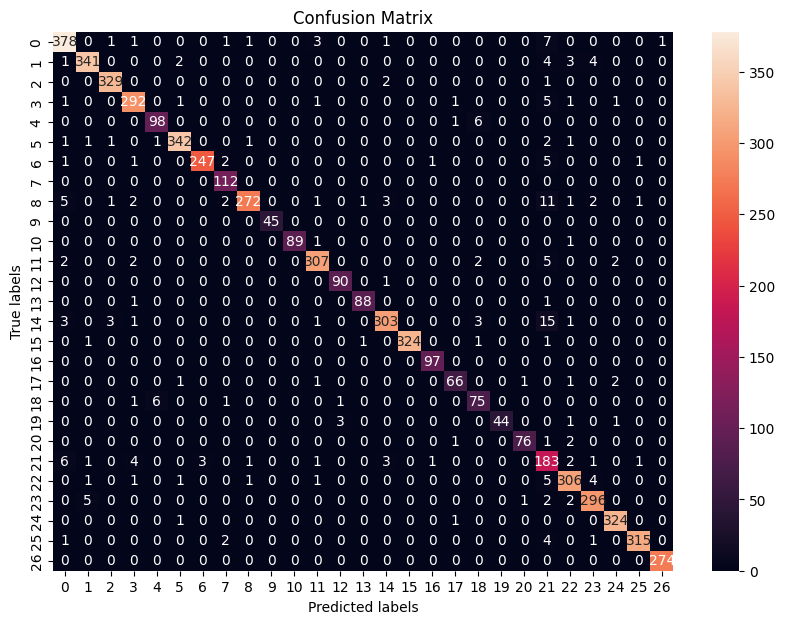

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

val_preds = []
val_targets = []
model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        val_preds.extend(predicted.cpu().numpy()) 
        val_targets.extend(labels.cpu().numpy()) 

cm = confusion_matrix(val_targets, val_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [16]:
import cv2
import torch
from torchvision import transforms
from PIL import Image
import numpy as np

# Load the trained model and set to evaluation mode
model = VGG13(num_classes=27)
model.load_state_dict(torch.load("final_200.h5", map_location=torch.device('cpu')))
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define transformations for each frameQ
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to preprocess frame and make predictions
def classify_frame(frame, model, device):
    # Convert frame to grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Convert grayscale to 3 channels
    gray_frame_3ch = cv2.merge([gray_frame, gray_frame, gray_frame])
    
    # Convert the frame to a PIL image and apply transformations
    pil_image = Image.fromarray(gray_frame_3ch)
    image_tensor = transform(pil_image).unsqueeze(0).to(device)

    # Run the image through the model to get prediction
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted_class = torch.max(output, 1)

    return predicted_class.item()

# OpenCV video capture
cap = cv2.VideoCapture(0) 

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    predicted_class = classify_frame(frame, model, device)

    label = f"Class: {predicted_class}"
    cv2.putText(frame, label, (10, frame.shape[0] - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    gray_display_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    cv2.imshow('Live Video Classification', cv2.merge([gray_display_frame, gray_display_frame, gray_display_frame]))

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
